# [Selección de características con sklearn y pandas](https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b)

## Introducción a los métodos de selección de características y su implementación en Python

<img src = 'https://miro.medium.com/max/1400/1*wnTXS4cPw-Tw_oC79VweTQ.jpeg'> 

La selección de características es uno de los primeros e importantes pasos al realizar cualquier tarea de aprendizaje automático. 

Una característica en el caso de un conjunto de datos simplemente significa una columna. 

Cuando obtenemos cualquier conjunto de datos, no necesariamente todas las columnas (características) van a tener un impacto en la variable de salida. 

Si agregamos estas características irrelevantes en el modelo, solo empeorará el modelo (Garbage In Garbage Out). 

Esto da lugar a la necesidad de hacer la selección de características.

Cuando se trata de la implementación de selección de características en Pandas, las características numéricas y categóricas deben tratarse de manera diferente. 

Aquí primero discutiremos sobre la selección de características numéricas. 

Por lo tanto, antes de implementar los siguientes métodos, debemos asegurarnos de que el DataFrame solo contenga características numéricas. 

Además, se discuten los siguientes métodos para el problema de regresión, lo que significa que tanto las variables de entrada como las de salida son de naturaleza continua.

La selección de características se puede hacer de múltiples maneras, pero en general hay 3 categorías:   

1. Método de filtro  
2. Método de contenedor     
3. Método embedded

## Acerca del conjunto de datos:  

Utilizaremos el conjunto de datos de Boston incorporado que se puede cargar a través de sklearn.

Seleccionaremos las características utilizando los métodos enumerados anteriormente para el problema de regresión de predecir la columna "MEDV". 

En el siguiente fragmento de código, importaremos todas las bibliotecas necesarias y cargaremos el conjunto de datos.

In [1]:
#importing libraries
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
#Loading the dataset
x = load_boston()
df = pd.DataFrame(x.data, columns = x.feature_names)
df["MEDV"] = x.target
X = df.drop("MEDV",1)   #Feature Matrix
y = df["MEDV"]          #Target Variable
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


## 1. Método de filtro:

Como su nombre indica, en este método, se filtra y se toma sólo el subconjunto de las características relevantes. 

El modelo se construye después de seleccionar las características. 

El filtrado aquí se realiza utilizando la matriz de correlación y se realiza más comúnmente utilizando la **correlación de Pearson**.

Aquí primero trazaremos el mapa de calor de correlación de Pearson y veremos la correlación de variables independientes con la variable de salida MEDV. 

Solo seleccionaremos características que tenga una correlación superior a 0.5 (tomando el valor absoluto) con la variable de salida.

El coeficiente de correlación tiene valores entre -1 a 1. 

— Un valor más cercano a 0 implica una correlación más débil (0 exacto que implica ninguna correlación) 

— Un valor más cercano a 1 implica una correlación positiva más fuerte 

— Un valor más cercano a -1 implica una correlación negativa más fuerte

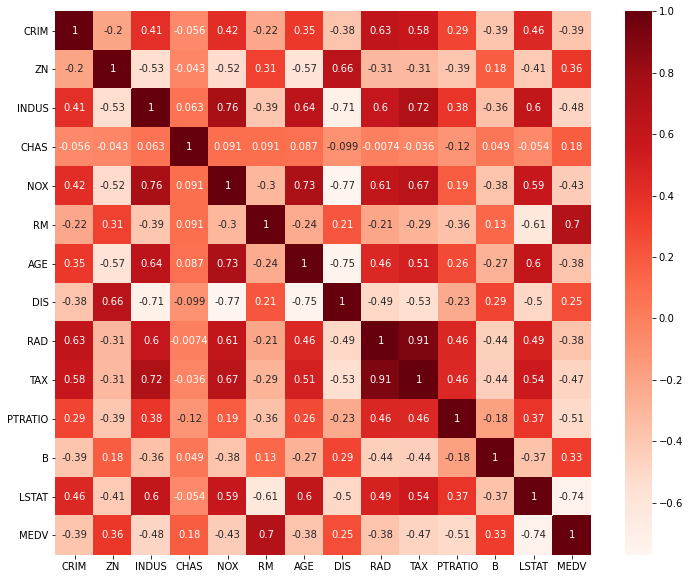

In [2]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [3]:
#Correlation with output variable
cor_target = abs(cor["MEDV"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features

RM         0.695360
PTRATIO    0.507787
LSTAT      0.737663
MEDV       1.000000
Name: MEDV, dtype: float64

Como podemos ver, solo las características `RM, PTRATIO` y `LSTAT` están altamente correlacionadas con la variable de salida `MEDV`. 

Por lo tanto, dejaremos de lado todas las demás características aparte de estas. 

Sin embargo, este no es el final del proceso. 

Uno de los supuestos de la regresión lineal es que las variables independientes deben no correlacionarse entre sí. 

Si estas variables están correlacionadas entre sí, entonces necesitamos mantener solo una de ellas y abandonar el resto. 

Así que vamos a comprobar la correlación de las características seleccionadas entre sí. 

Esto se puede hacer ya sea comprobándolo visualmente desde la matriz de correlación anterior o desde el fragmento de código a continuación.

In [4]:
print(df[["LSTAT","PTRATIO"]].corr())
print(df[["RM","LSTAT"]].corr())

            LSTAT   PTRATIO
LSTAT    1.000000  0.374044
PTRATIO  0.374044  1.000000
             RM     LSTAT
RM     1.000000 -0.613808
LSTAT -0.613808  1.000000


A partir del código anterior, se ve que las variables `RM` y `LSTAT` están altamente correlacionadas entre sí (-0.613808). 

Por lo tanto, mantendríamos solo una variable y dejaríamos caer la otra. 

Mantendremos `LSTAT` ya que su correlación con `MEDV` es mayor que la de `RM`.

Después de soltar `RM`, nos quedamos con dos características, LSTAT y PTRATIO. 

Estas son las características finales dadas por la correlación de Pearson.

## 2. Método de envoltura:  

Un método contenedor necesita un algoritmo de aprendizaje automático y utiliza su rendimiento como criterio de evaluación. 

Esto significa que alimenta las características al algoritmo de aprendizaje automático seleccionado y, en función del rendimiento del modelo, agrega o elimina las características. 

Este es un proceso iterativo y computacionalmente costoso, pero es más preciso que el método de filtro.

Existen diferentes métodos de envoltura como La eliminación hacia atrás, la selección hacia adelante, la eliminación bidireccional y RFE. 

Discutiremos la eliminación hacia atrás y RFE aquí.

### i. Eliminación hacia atrás  

Como su nombre indica, al principio alimentamos todas las características posibles al modelo. 

Comprobamos el rendimiento del modelo y luego eliminamos iterativamente las características de peor rendimiento una por una hasta que el rendimiento general del modelo llegue en un rango aceptable.

La métrica de rendimiento utilizada aquí para evaluar el rendimiento de las características es pvalue. Si el valor p está por encima de 0.05, eliminamos la función, de lo contrario la mantenemos.

Primero ejecutaremos una iteración aquí solo para tener una idea del concepto y luego ejecutaremos el mismo código en un bucle, que dará el conjunto final de características. 

Aquí estamos usando el modelo OLS que significa "Mínimos cuadrados ordinarios". 

Este modelo se utiliza para realizar la regresión lineal.

In [5]:
#Adding constant column of ones, mandatory for sm.OLS model
X_1 = sm.add_constant(X)
#Fitting sm.OLS model
model = sm.OLS(y,X_1).fit()
model.pvalues

const      3.283438e-12
CRIM       1.086810e-03
ZN         7.781097e-04
INDUS      7.382881e-01
CHAS       1.925030e-03
NOX        4.245644e-06
RM         1.979441e-18
AGE        9.582293e-01
DIS        6.013491e-13
RAD        5.070529e-06
TAX        1.111637e-03
PTRATIO    1.308835e-12
B          5.728592e-04
LSTAT      7.776912e-23
dtype: float64

Como podemos ver que la variable 'AGE' tiene el pvalue más alto de 0.9582293 que es mayor que 0.05. 

Por lo tanto, eliminaremos esta característica y construiremos el modelo una vez más. 

Este es un proceso iterativo y se puede realizar a la vez con la ayuda de loop. 

Este enfoque se implementa a continuación, lo que daría el conjunto final de variables que son CRIM, ZN, CHAS, NOX, RM, DIS, RAD, TAX, PTRATIO, B y LSTAT

In [6]:
#Backward Elimination
cols = list(X.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE)


['CRIM', 'ZN', 'CHAS', 'NOX', 'RM', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']


### ii. RFE (Eliminación de características recursivas)

El método de eliminación de características recursivas (RFE) funciona eliminando recursivamente atributos y creando un modelo sobre los atributos que quedan. 

Utiliza la métrica de precisión para clasificar la característica de acuerdo con su importancia. 

El método RFE toma el modelo que se utilizará y el número de características requeridas como entrada. A continuación, da la clasificación de todas las variables, siendo 1 la más importante. 

También da su apoyo, siendo True una característica relevante y False siendo una característica irrelevante.

In [8]:
model = LinearRegression()
#Initializing RFE model
rfe = RFE(model, 7)
#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  
#Fitting the data to model
model.fit(X_rfe,y)
print(rfe.support_)
print(rfe.ranking_)

[False False False  True  True  True False  True  True False  True False
  True]
[2 4 3 1 1 1 7 1 1 5 1 6 1]


C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=7 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Aquí tomamos el modelo LinearRegression con 7 características y RFE dio la clasificación de características como la anterior, pero la selección del número '7' fue aleatoria. Ahora necesitamos encontrar el número óptimo de características, para las cuales la precisión es la más alta. Lo hacemos usando el bucle que comienza con 1 función y sube a 13. 

Luego tomamos el que tiene la precisión es más alta.

In [10]:
#no of features
nof_list=np.arange(1,13)            
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))


C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=1 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=2 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass 

Optimum number of features: 10
Score with 10 features: 0.663581


C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=9 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=11 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pas

Como se ve en el código anterior, el número óptimo de características es 10. 

Ahora alimentamos 10 como número de características a RFE y obtenemos el conjunto final de características dadas por el método RFE, de la siguiente manera:

In [11]:
cols = list(X.columns)
model = LinearRegression()
#Initializing RFE model
rfe = RFE(model, 10)             
#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  
#Fitting the data to model
model.fit(X_rfe,y)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'DIS', 'RAD', 'PTRATIO',
       'LSTAT'],
      dtype='object')


C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


### 3. Método incrustado  

Los métodos integrados son iterativos en un sentido que se encarga de cada iteración del proceso de entrenamiento del modelo y extrae cuidadosamente aquellas características que más contribuyen al entrenamiento para una iteración en particular. 

Los métodos de regularización son los métodos integrados más utilizados que penalizan una característica dado un umbral de coeficiente.
Aquí haremos la selección de características utilizando la regularización de Lazo. Si la característica es irrelevante, el lazo penaliza su coeficiente y lo convierte en 0. Por lo tanto, las características con coeficiente = 0 se eliminan y se toma el resto.

In [12]:
reg = LassoCV()
reg.fit(X, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,y))
coef = pd.Series(reg.coef_, index = X.columns)

Best alpha using built-in LassoCV: 0.724820
Best score using built-in LassoCV: 0.702444


In [13]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 10 variables and eliminated the other 3 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

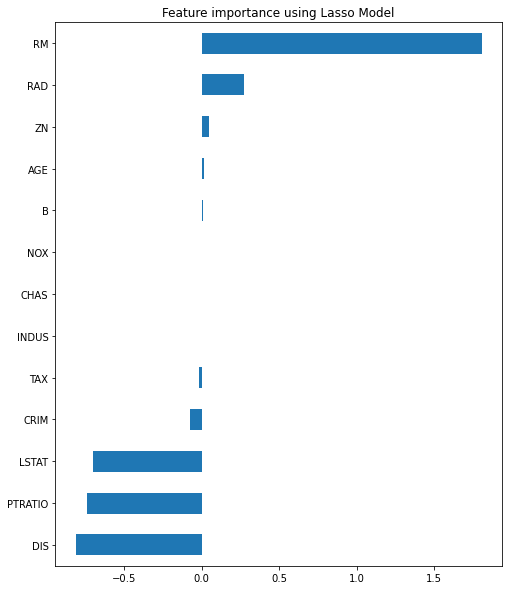

In [14]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

Aquí el modelo Lasso ha tomado todas las características excepto NOX, CHAS e INDUS.

## Conclusión:  

Vimos cómo seleccionar características utilizando múltiples métodos para datos numéricos y comparamos sus resultados. 

Ahora surge una confusión de qué método elegir en qué situación. 

Los siguientes puntos te ayudarán a tomar esta decisión.

El método de filtro es menos preciso. 

Es genial al hacer EDA, también se puede usar para verificar la co-linealidad múltiple en los datos.

Los métodos Wrapper e Embedded dan resultados más precisos, pero como son computacionalmente caros, estos métodos son adecuados cuando tiene características menores (~ 20).

En el próximo blog echaremos un vistazo a algunos métodos de selección de características más para seleccionar características numéricas y categóricas.